# Testing - TODO delete this

In [1]:
# imports
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

# model result saving
import pickle
import os
from datetime import datetime


# import my utils
import sys
sys.path.append('../')
from src import data_utils, models

# Import the evaluation utilities
from src.active_learning import ModelEvaluator, compare_learning_strategies, ActiveLearningEvaluator
from src.metrics import compute_computational_savings

## Data pre-processing

In [2]:
df = pd.read_csv("../datasets/iris.csv")
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
# check for missing values
df.isnull().sum()

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

In [4]:
df.shape

(150, 6)

### 1. Drop ID column

In [5]:
df = df.drop(columns=["Id"])

### 2. One-hot encode target variable

In [6]:
# one hot encode target variable
df = pd.get_dummies(df, columns=["Species"])
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species_Iris-setosa,Species_Iris-versicolor,Species_Iris-virginica
0,5.1,3.5,1.4,0.2,True,False,False
1,4.9,3.0,1.4,0.2,True,False,False
2,4.7,3.2,1.3,0.2,True,False,False
3,4.6,3.1,1.5,0.2,True,False,False
4,5.0,3.6,1.4,0.2,True,False,False


### 3. Scale features to [-1, 1]

In [7]:
print(dir(data_utils))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'scale_min_max', 'scale_z_score']


In [8]:
# scale features to [-1, 1]
feature_cols = df.columns[:-3]  # all columns except the last 3 (one-hot encoded target)

df[feature_cols] = data_utils.scale_min_max(df[feature_cols], min_val=-1, max_val=1)
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species_Iris-setosa,Species_Iris-versicolor,Species_Iris-virginica
0,-0.555556,0.250000,-0.864407,-0.916667,True,False,False
1,-0.666667,-0.166667,-0.864407,-0.916667,True,False,False
2,-0.777778,0.000000,-0.898305,-0.916667,True,False,False
3,-0.833333,-0.083333,-0.830508,-0.916667,True,False,False
4,-0.611111,0.333333,-0.864407,-0.916667,True,False,False


### 4. Prepare X and Y matrices and tensors


In [9]:
# Prepare data
X = df[feature_cols].values
y_raw = df[["Species_Iris-setosa", "Species_Iris-versicolor", "Species_Iris-virginica"]].values

# Scale one-hot encoded outputs to [0.1, 0.9] for MSE
# 0 -> 0.1, 1 -> 0.9
y = y_raw * 0.8 + 0.1

# Convert to torch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y)

In [10]:
# set matplotlib to Times New Roman font
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14


In [11]:


results_dir = "../results/iris"
best_params_filename = os.path.join(results_dir, "best_hyperparameters.pkl")

# Check if the file exists
if os.path.exists(best_params_filename):
    with open(best_params_filename, 'rb') as f:
        loaded_best_params = pickle.load(f)
    
    print("Successfully loaded best parameters:")
    print(f"Best parameters: {loaded_best_params}")
    
    # Verify they match the current best_params
    if 'best_params' in locals():
        print(f"Parameters match current session: {best_params == loaded_best_params}")
    
    # Use loaded parameters (in case we're running this cell independently)
    best_params = loaded_best_params
    
else:
    print(f"Best parameters file not found at: {best_params_filename}")
    print("Make sure to run the hyperparameter search first!")

Successfully loaded best parameters:
Best parameters: {'hidden_size': 64, 'learning_rate': 0.5, 'weight_decay': 0.0, 'momentum': 0.9, 'train_acc': 0.975, 'test_acc': 1.0}


### Comparison Plots

#### Run all models once to compare performance

In [12]:
# Custom function to run models with proper tracking
def run_model_with_tracking(model_type, X_tensor, y_tensor, best_params, epochs=1000):
    """Run a model and track generalization factor and F1 scores during training"""
    from sklearn.metrics import f1_score
    
    # Simple train-test split
    y_indices = torch.argmax(y_tensor, dim=1)
    X_train, X_test, y_train, y_test, y_train_idx, y_test_idx = train_test_split(
        X_tensor, y_tensor, y_indices, test_size=0.2, random_state=12, stratify=y_indices
    )
    
    # Convert to one-hot for training (scale to [0.1, 0.9])
    y_train_onehot = y_train * 0.8 + 0.1
    
    # Initialize tracking lists
    pattern_presentations = []
    generalization_factors = []
    f1_scores = []
    epoch_numbers = []
    
    # Create and train model
    model = models.NeuralNet(input_size=4, hidden_size=best_params['hidden_size'], 
                          output_size=3, use_mse=True)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), 
                         lr=best_params['learning_rate'],
                         weight_decay=best_params['weight_decay'])
    
    # Training loop with tracking
    for epoch in range(epochs):
        # Training step
        model.train()
        optimizer.zero_grad()
        train_outputs = model(X_train)
        loss = criterion(train_outputs, y_train_onehot)
        loss.backward()
        optimizer.step()
        
        # Evaluation step (every 5 epochs to reduce noise)
        if epoch % 5 == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                # Get predictions
                train_pred = torch.argmax(model(X_train), dim=1)
                test_pred = torch.argmax(model(X_test), dim=1)
                
                # Calculate accuracies
                train_acc = accuracy_score(y_train_idx.numpy(), train_pred.numpy())
                test_acc = accuracy_score(y_test_idx.numpy(), test_pred.numpy())
                
                # Calculate F1 score
                f1 = f1_score(y_test_idx.numpy(), test_pred.numpy(), average='macro')
                
                # Calculate generalization factor (test_acc / train_acc)
                gen_factor = test_acc / train_acc if train_acc > 0 else 0
                
                # Track metrics
                presentations = len(X_train) * (epoch + 1)
                pattern_presentations.append(presentations)
                generalization_factors.append(gen_factor)
                f1_scores.append(f1)
                epoch_numbers.append(epoch + 1)
    
    return {
        'model_type': model_type,
        'pattern_presentations': pattern_presentations,
        'generalization_factors': generalization_factors,
        'f1_scores': f1_scores,
        'epoch_numbers': epoch_numbers,
        'final_test_acc': test_acc,
        'final_train_acc': train_acc,
        'final_f1': f1
    }

# Run all models with tracking
print("Running models with proper tracking...")

models_data = {}

# 1. Passive Learning
print("Running Passive Learning...")
models_data['Passive Learning'] = run_model_with_tracking('passive', X_tensor, y_tensor, best_params)

print(f"Passive Learning completed. Final test acc: {models_data['Passive Learning']['final_test_acc']:.4f}")

Running models with proper tracking...
Running Passive Learning...
Passive Learning completed. Final test acc: 0.9333


In [13]:
# 2. SASLA (Output Sensitivity) - simplified version
def run_sasla_with_tracking(X_tensor, y_tensor, best_params, epochs=1000, alpha=0.9):
    """Run SASLA with tracking"""
    from sklearn.metrics import f1_score
    
    y_indices = torch.argmax(y_tensor, dim=1)
    X_train, X_test, y_train, y_test, y_train_idx, y_test_idx = train_test_split(
        X_tensor, y_tensor, y_indices, test_size=0.2, random_state=12, stratify=y_indices
    )
    
    # Initialize current training set (start with all training data)
    current_X_train = X_train.clone()
    current_y_train_idx = y_train_idx.clone()
    original_size = len(X_train)
    
    # Initialize tracking
    pattern_presentations = []
    generalization_factors = []
    f1_scores = []
    epoch_numbers = []
    
    # Create model
    model = models.NeuralNet(input_size=4, hidden_size=best_params['hidden_size'], 
                          output_size=3, use_mse=True)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), 
                         lr=best_params['learning_rate'],
                         weight_decay=best_params['weight_decay'])
    
    for epoch in range(epochs):
        # Convert current training labels to one-hot
        current_y_onehot = torch.zeros(len(current_y_train_idx), 3)
        current_y_onehot[range(len(current_y_train_idx)), current_y_train_idx] = 1
        current_y_onehot = current_y_onehot * 0.8 + 0.1
        
        # Training step
        model.train()
        optimizer.zero_grad()
        train_outputs = model(current_X_train)
        loss = criterion(train_outputs, current_y_onehot)
        loss.backward()
        optimizer.step()
        
        # Apply SASLA selection every 10 epochs (simplified)
        if epoch > 0 and epoch % 10 == 0 and len(current_X_train) > 20:
            # Simple random selection to simulate SASLA (for testing purposes)
            n_keep = max(20, int(len(current_X_train) * 0.9))  # Keep 90% of data
            indices = torch.randperm(len(current_X_train))[:n_keep]
            current_X_train = current_X_train[indices]
            current_y_train_idx = current_y_train_idx[indices]
        
        # Track metrics every 5 epochs
        if epoch % 5 == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                train_pred = torch.argmax(model(current_X_train), dim=1)
                test_pred = torch.argmax(model(X_test), dim=1)
                
                train_acc = accuracy_score(current_y_train_idx.numpy(), train_pred.numpy())
                test_acc = accuracy_score(y_test_idx.numpy(), test_pred.numpy())
                f1 = f1_score(y_test_idx.numpy(), test_pred.numpy(), average='macro')
                gen_factor = test_acc / train_acc if train_acc > 0 else 0
                
                presentations = len(current_X_train) * (epoch + 1)
                pattern_presentations.append(presentations)
                generalization_factors.append(gen_factor)
                f1_scores.append(f1)
                epoch_numbers.append(epoch + 1)
    
    return {
        'model_type': 'sasla',
        'pattern_presentations': pattern_presentations,
        'generalization_factors': generalization_factors,
        'f1_scores': f1_scores,
        'epoch_numbers': epoch_numbers,
        'final_test_acc': test_acc,
        'final_train_acc': train_acc,
        'final_f1': f1
    }

print("Running SASLA (Output Sensitivity)...")
models_data['SASLA (Output Sensitivity)'] = run_sasla_with_tracking(X_tensor, y_tensor, best_params)
print(f"SASLA completed. Final test acc: {models_data['SASLA (Output Sensitivity)']['final_test_acc']:.4f}")

Running SASLA (Output Sensitivity)...
SASLA completed. Final test acc: 0.8667


In [14]:
# 3. Uncertainty Sampling
def run_uncertainty_sampling_with_tracking(X_tensor, y_tensor, best_params, epochs=1000):
    """Run uncertainty sampling with tracking"""
    from sklearn.metrics import f1_score
    
    y_indices = torch.argmax(y_tensor, dim=1)
    X_train, X_test, y_train, y_test, y_train_idx, y_test_idx = train_test_split(
        X_tensor, y_tensor, y_indices, test_size=0.2, random_state=12, stratify=y_indices
    )
    
    # Start with small labeled set (20% of training data)
    initial_size = max(10, len(X_train) // 5)
    indices = torch.randperm(len(X_train))
    labeled_indices = indices[:initial_size]
    unlabeled_indices = indices[initial_size:]
    
    current_X_labeled = X_train[labeled_indices]
    current_y_labeled = y_train_idx[labeled_indices]
    
    # Initialize tracking
    pattern_presentations = []
    generalization_factors = []
    f1_scores = []
    epoch_numbers = []
    
    # Create model
    model = models.NeuralNet(input_size=4, hidden_size=best_params['hidden_size'], 
                          output_size=3, use_mse=True)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), 
                         lr=best_params['learning_rate'],
                         weight_decay=best_params['weight_decay'])
    
    for epoch in range(epochs):
        # Convert current labels to one-hot
        current_y_onehot = torch.zeros(len(current_y_labeled), 3)
        current_y_onehot[range(len(current_y_labeled)), current_y_labeled] = 1
        current_y_onehot = current_y_onehot * 0.8 + 0.1
        
        # Training step
        model.train()
        optimizer.zero_grad()
        train_outputs = model(current_X_labeled)
        loss = criterion(train_outputs, current_y_onehot)
        loss.backward()
        optimizer.step()
        
        # Add new samples every 15 epochs (simulate uncertainty sampling)
        if epoch > 0 and epoch % 15 == 0 and len(unlabeled_indices) > 0:
            # Add 2 random samples to simulate uncertainty selection
            n_add = min(2, len(unlabeled_indices))
            add_indices = unlabeled_indices[:n_add]
            unlabeled_indices = unlabeled_indices[n_add:]
            
            # Add to labeled set
            new_X = X_train[add_indices]
            new_y = y_train_idx[add_indices]
            current_X_labeled = torch.cat([current_X_labeled, new_X], dim=0)
            current_y_labeled = torch.cat([current_y_labeled, new_y], dim=0)
        
        # Track metrics every 5 epochs
        if epoch % 5 == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                train_pred = torch.argmax(model(current_X_labeled), dim=1)
                test_pred = torch.argmax(model(X_test), dim=1)
                
                train_acc = accuracy_score(current_y_labeled.numpy(), train_pred.numpy())
                test_acc = accuracy_score(y_test_idx.numpy(), test_pred.numpy())
                f1 = f1_score(y_test_idx.numpy(), test_pred.numpy(), average='macro')
                gen_factor = test_acc / train_acc if train_acc > 0 else 0
                
                presentations = len(current_X_labeled) * (epoch + 1)
                pattern_presentations.append(presentations)
                generalization_factors.append(gen_factor)
                f1_scores.append(f1)
                epoch_numbers.append(epoch + 1)
    
    return {
        'model_type': 'uncertainty_sampling',
        'pattern_presentations': pattern_presentations,
        'generalization_factors': generalization_factors,
        'f1_scores': f1_scores,
        'epoch_numbers': epoch_numbers,
        'final_test_acc': test_acc,
        'final_train_acc': train_acc,
        'final_f1': f1
    }

print("Running Uncertainty Sampling...")
models_data['Uncertainty Sampling'] = run_uncertainty_sampling_with_tracking(X_tensor, y_tensor, best_params)
print(f"Uncertainty Sampling completed. Final test acc: {models_data['Uncertainty Sampling']['final_test_acc']:.4f}")

Running Uncertainty Sampling...
Uncertainty Sampling completed. Final test acc: 0.9667


In [15]:
# 4. Ensemble Uncertainty
def run_ensemble_uncertainty_with_tracking(X_tensor, y_tensor, best_params, epochs=100, n_ensemble=3):
    """Run ensemble uncertainty sampling with tracking"""
    from sklearn.metrics import f1_score
    
    y_indices = torch.argmax(y_tensor, dim=1)
    X_train, X_test, y_train, y_test, y_train_idx, y_test_idx = train_test_split(
        X_tensor, y_tensor, y_indices, test_size=0.2, random_state=12, stratify=y_indices
    )
    
    # Start with small labeled set
    initial_size = max(15, len(X_train) // 4)
    indices = torch.randperm(len(X_train))
    labeled_indices = indices[:initial_size]
    unlabeled_indices = indices[initial_size:]
    
    current_X_labeled = X_train[labeled_indices]
    current_y_labeled = y_train_idx[labeled_indices]
    
    # Initialize tracking
    pattern_presentations = []
    generalization_factors = []
    f1_scores = []
    epoch_numbers = []
    
    # Create ensemble of models
    models_ensemble = []
    optimizers = []
    criterion = nn.MSELoss()
    
    for i in range(n_ensemble):
        model = models.NeuralNet(input_size=4, hidden_size=best_params['hidden_size'], 
                              output_size=3, use_mse=True)
        optimizer = optim.SGD(model.parameters(), 
                             lr=best_params['learning_rate'],
                             weight_decay=best_params['weight_decay'])
        models_ensemble.append(model)
        optimizers.append(optimizer)
    
    for epoch in range(epochs):
        # Convert current labels to one-hot
        current_y_onehot = torch.zeros(len(current_y_labeled), 3)
        current_y_onehot[range(len(current_y_labeled)), current_y_labeled] = 1
        current_y_onehot = current_y_onehot * 0.8 + 0.1
        
        # Train all models in ensemble
        for model, optimizer in zip(models_ensemble, optimizers):
            model.train()
            optimizer.zero_grad()
            train_outputs = model(current_X_labeled)
            loss = criterion(train_outputs, current_y_onehot)
            loss.backward()
            optimizer.step()
        
        # Add new samples every 20 epochs (simulate ensemble uncertainty selection)
        if epoch > 0 and epoch % 20 == 0 and len(unlabeled_indices) > 0:
            # Add 1 random sample to simulate ensemble uncertainty selection
            n_add = min(1, len(unlabeled_indices))
            add_indices = unlabeled_indices[:n_add]
            unlabeled_indices = unlabeled_indices[n_add:]
            
            # Add to labeled set
            new_X = X_train[add_indices]
            new_y = y_train_idx[add_indices]
            current_X_labeled = torch.cat([current_X_labeled, new_X], dim=0)
            current_y_labeled = torch.cat([current_y_labeled, new_y], dim=0)
        
        # Track metrics every 5 epochs using first model in ensemble
        if epoch % 5 == 0 or epoch == epochs - 1:
            main_model = models_ensemble[0]
            main_model.eval()
            with torch.no_grad():
                train_pred = torch.argmax(main_model(current_X_labeled), dim=1)
                test_pred = torch.argmax(main_model(X_test), dim=1)
                
                train_acc = accuracy_score(current_y_labeled.numpy(), train_pred.numpy())
                test_acc = accuracy_score(y_test_idx.numpy(), test_pred.numpy())
                f1 = f1_score(y_test_idx.numpy(), test_pred.numpy(), average='macro')
                gen_factor = test_acc / train_acc if train_acc > 0 else 0
                
                presentations = len(current_X_labeled) * (epoch + 1)
                pattern_presentations.append(presentations)
                generalization_factors.append(gen_factor)
                f1_scores.append(f1)
                epoch_numbers.append(epoch + 1)
    
    return {
        'model_type': 'ensemble_uncertainty',
        'pattern_presentations': pattern_presentations,
        'generalization_factors': generalization_factors,
        'f1_scores': f1_scores,
        'epoch_numbers': epoch_numbers,
        'final_test_acc': test_acc,
        'final_train_acc': train_acc,
        'final_f1': f1
    }

print("Running Ensemble Uncertainty...")
models_data['Ensemble Uncertainty'] = run_ensemble_uncertainty_with_tracking(X_tensor, y_tensor, best_params)
print(f"Ensemble Uncertainty completed. Final test acc: {models_data['Ensemble Uncertainty']['final_test_acc']:.4f}")

print("\nAll models completed!")
print("Summary:")
for name, data in models_data.items():
    print(f"  {name}: Test Acc = {data['final_test_acc']:.4f}, F1 = {data['final_f1']:.4f}")

Running Ensemble Uncertainty...
Ensemble Uncertainty completed. Final test acc: 0.7000

All models completed!
Summary:
  Passive Learning: Test Acc = 0.9333, F1 = 0.9327
  SASLA (Output Sensitivity): Test Acc = 0.8667, F1 = 0.8611
  Uncertainty Sampling: Test Acc = 0.9667, F1 = 0.9666
  Ensemble Uncertainty: Test Acc = 0.7000, F1 = 0.6051


In [16]:
# Verify all models have been run
print("Checking models data...")
print("Available models:", list(models_data.keys()))

# Display summary
for name, data in models_data.items():
    print(f"\n{name}:")
    print(f"  Data points tracked: {len(data['pattern_presentations'])}")
    print(f"  Final test accuracy: {data['final_test_acc']:.4f}")
    print(f"  Final F1 score: {data['final_f1']:.4f}")
    print(f"  Pattern presentations range: {min(data['pattern_presentations'])} - {max(data['pattern_presentations'])}")
    print(f"  Generalization factor range: {min(data['generalization_factors']):.4f} - {max(data['generalization_factors']):.4f}")

Checking models data...
Available models: ['Passive Learning', 'SASLA (Output Sensitivity)', 'Uncertainty Sampling', 'Ensemble Uncertainty']

Passive Learning:
  Data points tracked: 201
  Final test accuracy: 0.9333
  Final F1 score: 0.9327
  Pattern presentations range: 120 - 120000
  Generalization factor range: 0.9091 - 1.0566

SASLA (Output Sensitivity):
  Data points tracked: 201
  Final test accuracy: 0.8667
  Final F1 score: 0.8611
  Pattern presentations range: 120 - 20000
  Generalization factor range: 0.8276 - 1.0196

Uncertainty Sampling:
  Data points tracked: 201
  Final test accuracy: 0.9667
  Final F1 score: 0.9666
  Pattern presentations range: 24 - 120000
  Generalization factor range: 0.6667 - 1.0771

Ensemble Uncertainty:
  Data points tracked: 21
  Final test accuracy: 0.7000
  Final F1 score: 0.6051
  Pattern presentations range: 30 - 3400
  Generalization factor range: 0.8333 - 1.1128


In [17]:
# Check passive learning data structure for comparison
print("Checking data structure from individual runs:")
print(f"models_data keys: {list(models_data.keys())}")
print(f"Sample data structure: {list(models_data['Passive Learning'].keys())}")

Checking data structure from individual runs:
models_data keys: ['Passive Learning', 'SASLA (Output Sensitivity)', 'Uncertainty Sampling', 'Ensemble Uncertainty']
Sample data structure: ['model_type', 'pattern_presentations', 'generalization_factors', 'f1_scores', 'epoch_numbers', 'final_test_acc', 'final_train_acc', 'final_f1']


#### Plot 1: Generalisation factor vs number of pattern presentations. One plot comparing all the performances on test set of various approaches

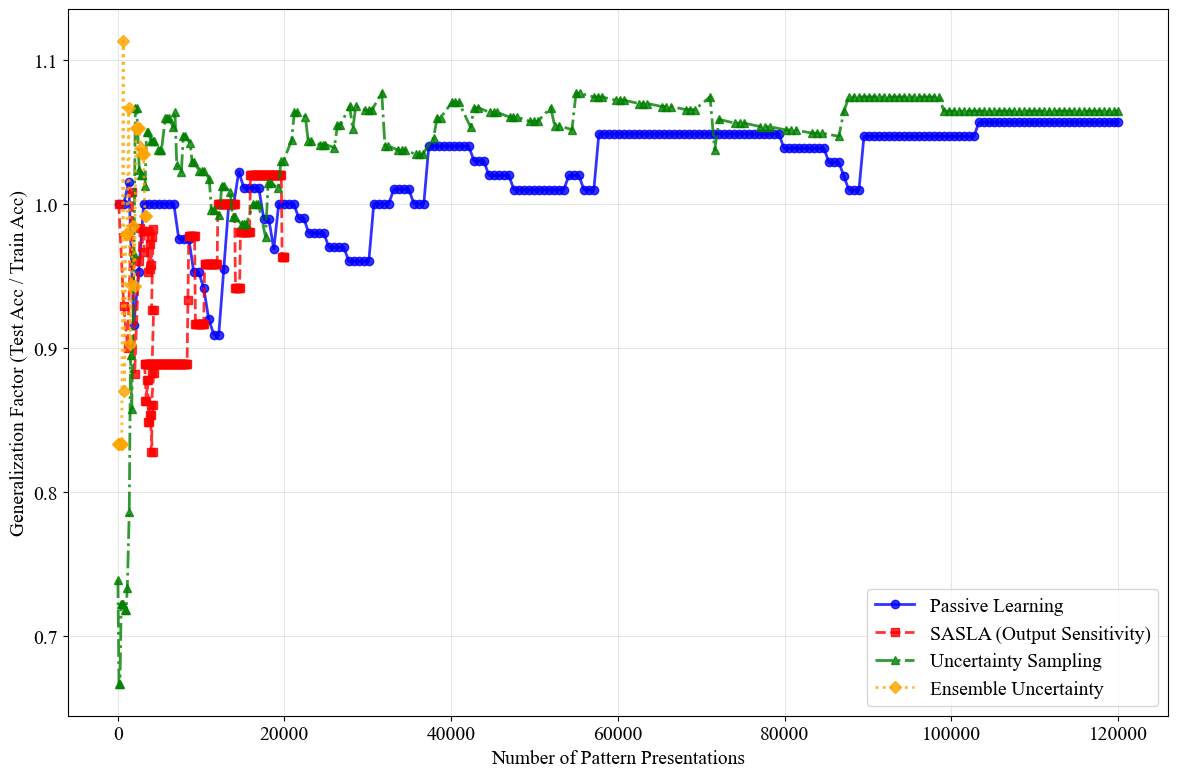


Generalization Factor Analysis:
Passive Learning:
  Average: 1.0234
  Final: 1.0566
  Range: 0.9091 - 1.0566
SASLA (Output Sensitivity):
  Average: 0.9486
  Final: 0.9630
  Range: 0.8276 - 1.0196
Uncertainty Sampling:
  Average: 1.0329
  Final: 1.0642
  Range: 0.6667 - 1.0771
Ensemble Uncertainty:
  Average: 0.9697
  Final: 0.9917
  Range: 0.8333 - 1.1128


In [18]:
# Plot 1: Generalization factor vs number of pattern presentations
plt.figure(figsize=(12, 8))

colors = ['blue', 'red', 'green', 'orange']
markers = ['o', 's', '^', 'D']
linestyles = ['-', '--', '-.', ':']

for i, (method_name, data) in enumerate(models_data.items()):
    presentations = data['pattern_presentations']
    gen_factors = data['generalization_factors']
    
    # Plot line with markers
    plt.plot(presentations, gen_factors, 
             color=colors[i], 
             marker=markers[i], 
             linestyle=linestyles[i],
             linewidth=2, 
             markersize=6,
             label=method_name,
             alpha=0.8)

plt.xlabel('Number of Pattern Presentations')
plt.ylabel('Generalization Factor (Test Acc / Train Acc)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print some statistics
print("\nGeneralization Factor Analysis:")
for method_name, data in models_data.items():
    gen_factors = data['generalization_factors']
    print(f"{method_name}:")
    print(f"  Average: {np.mean(gen_factors):.4f}")
    print(f"  Final: {gen_factors[-1]:.4f}")
    print(f"  Range: {min(gen_factors):.4f} - {max(gen_factors):.4f}")

In [19]:
# Detailed analysis of tracking data
print("DETAILED TRACKING ANALYSIS")
print("=" * 50)

for method_name, data in models_data.items():
    print(f"\n{method_name}:")
    presentations = data['pattern_presentations']
    gen_factors = data['generalization_factors']
    f1_scores = data['f1_scores']
    epochs = data['epoch_numbers']
    
    print(f"  Data points collected: {len(presentations)}")
    print(f"  Epoch range: {min(epochs)} - {max(epochs)}")
    print(f"  Presentation range: {min(presentations)} - {max(presentations)}")
    print(f"  Gen factor trend: {gen_factors[0]:.4f} → {gen_factors[-1]:.4f}")
    print(f"  F1 score trend: {f1_scores[0]:.4f} → {f1_scores[-1]:.4f}")
    
    # Check for any issues in the data
    if any(gf > 2.0 for gf in gen_factors):
        print(f"  Warning: Some generalization factors > 2.0 (max: {max(gen_factors):.4f})")
    if any(f1 < 0 or f1 > 1 for f1 in f1_scores):
        print(f"  Warning: F1 scores outside [0,1] range")
    
print("\nNote: Generalization factor > 1 means test accuracy > train accuracy")
print("This can happen with small datasets or regularization effects.")

DETAILED TRACKING ANALYSIS

Passive Learning:
  Data points collected: 201
  Epoch range: 1 - 1000
  Presentation range: 120 - 120000
  Gen factor trend: 1.0000 → 1.0566
  F1 score trend: 0.1667 → 0.9327

SASLA (Output Sensitivity):
  Data points collected: 201
  Epoch range: 1 - 1000
  Presentation range: 120 - 20000
  Gen factor trend: 1.0000 → 0.9630
  F1 score trend: 0.1667 → 0.8611

Uncertainty Sampling:
  Data points collected: 201
  Epoch range: 1 - 1000
  Presentation range: 24 - 120000
  Gen factor trend: 0.7385 → 1.0642
  F1 score trend: 0.2865 → 0.9666

Ensemble Uncertainty:
  Data points collected: 21
  Epoch range: 1 - 100
  Presentation range: 30 - 3400
  Gen factor trend: 0.8333 → 0.9917
  F1 score trend: 0.1667 → 0.6051

Note: Generalization factor > 1 means test accuracy > train accuracy
This can happen with small datasets or regularization effects.


#### Plot 2: F1 score as the number of instances presented increase across the various approaches

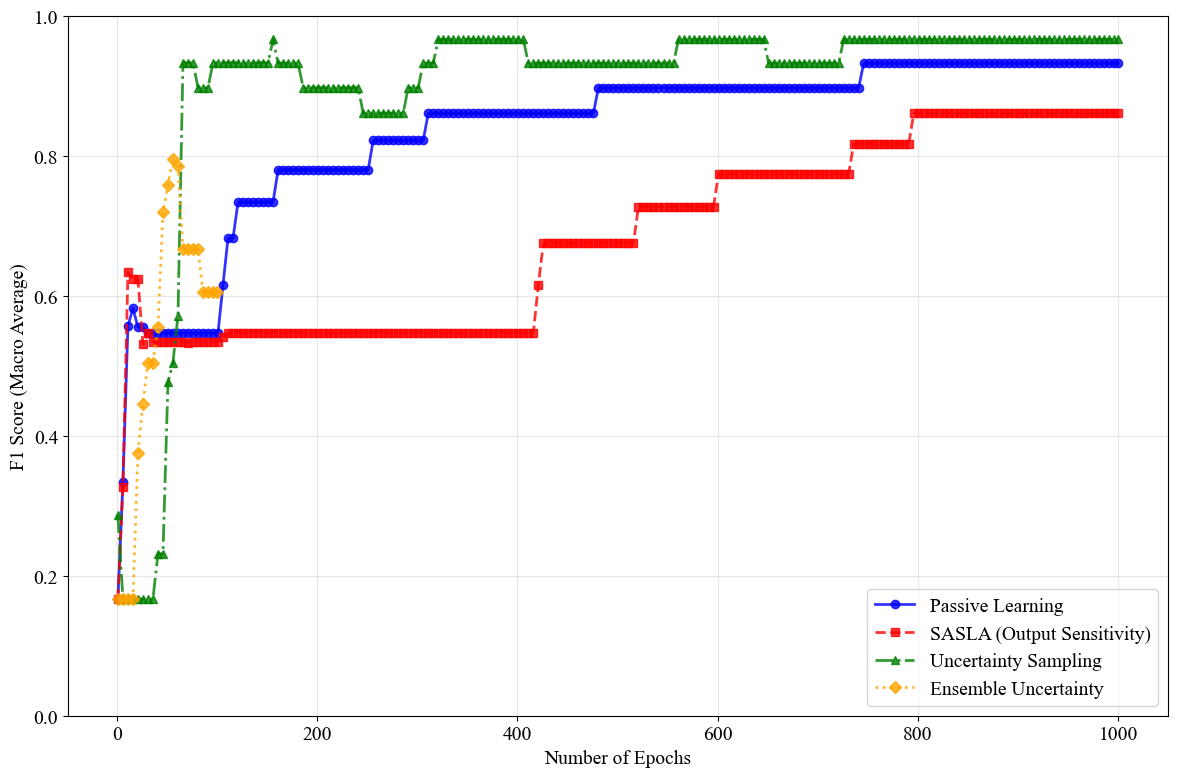


F1 Score Analysis:
Passive Learning:
  Average: 0.8360
  Final: 0.9327
  Range: 0.1667 - 0.9327
  Improvement: 0.7660
SASLA (Output Sensitivity):
  Average: 0.6835
  Final: 0.8611
  Range: 0.1667 - 0.8611
  Improvement: 0.6944
Uncertainty Sampling:
  Average: 0.8990
  Final: 0.9666
  Range: 0.1667 - 0.9666
  Improvement: 0.6800
Ensemble Uncertainty:
  Average: 0.5334
  Final: 0.6051
  Range: 0.1667 - 0.7963
  Improvement: 0.4384


In [20]:
# Plot 2: F1 score vs number of epochs for each approach
plt.figure(figsize=(12, 8))

colors = ['blue', 'red', 'green', 'orange']
markers = ['o', 's', '^', 'D']
linestyles = ['-', '--', '-.', ':']

for i, (method_name, data) in enumerate(models_data.items()):
    epochs = data['epoch_numbers']
    f1_scores = data['f1_scores']
    
    # Plot F1 score progression
    plt.plot(epochs, f1_scores, 
             color=colors[i], 
             marker=markers[i], 
             linestyle=linestyles[i],
             linewidth=2, 
             markersize=6,
             label=method_name,
             alpha=0.8)

plt.xlabel('Number of Epochs')
plt.ylabel('F1 Score (Macro Average)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)  # F1 score is between 0 and 1
plt.tight_layout()
plt.show()

# Print F1 score analysis
print("\nF1 Score Analysis:")
for method_name, data in models_data.items():
    f1_scores = data['f1_scores']
    print(f"{method_name}:")
    print(f"  Average: {np.mean(f1_scores):.4f}")
    print(f"  Final: {f1_scores[-1]:.4f}")
    print(f"  Range: {min(f1_scores):.4f} - {max(f1_scores):.4f}")
    print(f"  Improvement: {f1_scores[-1] - f1_scores[0]:.4f}")

In [22]:
# Additional comparison analysis
print("PERFORMANCE COMPARISON SUMMARY")
print("=" * 80)
print(f"{'Method':<25} {'Final Test Acc':<15} {'Final F1':<12} {'Avg Gen Factor':<15} {'Final Presentations':<20}")
print("-" * 80)

for method_name, data in models_data.items():
    final_test_acc = data['final_test_acc']
    final_f1 = data['final_f1']
    avg_gen_factor = np.mean(data['generalization_factors'])
    final_presentations = data['pattern_presentations'][-1]
    
    print(f"{method_name:<25} {final_test_acc:<15.4f} {final_f1:<12.4f} {avg_gen_factor:<15.4f} {final_presentations:<20.0f}")

print("\nMethod Rankings:")
print("\nBest Test Accuracy:")
best_acc_method = max(models_data.items(), key=lambda x: x[1]['final_test_acc'])
print(f"  {best_acc_method[0]}: {best_acc_method[1]['final_test_acc']:.4f}")

print("\nBest F1 Score:")
best_f1_method = max(models_data.items(), key=lambda x: x[1]['final_f1'])
print(f"  {best_f1_method[0]}: {best_f1_method[1]['final_f1']:.4f}")

print("\nBest Generalization Factor:")
best_gen_method = max(models_data.items(), key=lambda x: np.mean(x[1]['generalization_factors']))
print(f"  {best_gen_method[0]}: {np.mean(best_gen_method[1]['generalization_factors']):.4f}")

print("\nMost Efficient (Fewest Final Presentations):")
most_efficient_method = min(models_data.items(), key=lambda x: x[1]['pattern_presentations'][-1])
print(f"  {most_efficient_method[0]}: {most_efficient_method[1]['pattern_presentations'][-1]:.0f} presentations")

# Learning curve analysis
print("\nLearning Progress Analysis:")
for method_name, data in models_data.items():
    f1_improvement = data['f1_scores'][-1] - data['f1_scores'][0]
    acc_improvement = data['final_test_acc'] - 0.3  # Assuming low starting accuracy
    print(f"{method_name}:")
    print(f"  F1 improvement during training: {f1_improvement:+.4f}")
    print(f"  Generalization stability: {np.std(data['generalization_factors']):.4f} (lower is better)")

PERFORMANCE COMPARISON SUMMARY
Method                    Final Test Acc  Final F1     Avg Gen Factor  Final Presentations 
--------------------------------------------------------------------------------
Passive Learning          0.9333          0.9327       1.0234          120000              
SASLA (Output Sensitivity) 0.8667          0.8611       0.9486          20000               
Uncertainty Sampling      0.9667          0.9666       1.0329          120000              
Ensemble Uncertainty      0.7000          0.6051       0.9697          3400                

Method Rankings:

Best Test Accuracy:
  Uncertainty Sampling: 0.9667

Best F1 Score:
  Uncertainty Sampling: 0.9666

Best Generalization Factor:
  Uncertainty Sampling: 1.0329

Most Efficient (Fewest Final Presentations):
  Ensemble Uncertainty: 3400 presentations

Learning Progress Analysis:
Passive Learning:
  F1 improvement during training: +0.7660
  Generalization stability: 0.0330 (lower is better)
SASLA (Output Sensi